# Определение тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

**Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.**


**Описание тарифов**
- тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
- Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

## Шаг 1. Откроем файлы с данными и изучим общую информацию

### Описание данных

**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
# подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats as st

In [2]:
#!pip3 install plotly

In [3]:
# читаем данные
local = False

if local: 
    users = pd.read_csv('./datasets/users.csv')
    calls = pd.read_csv('./datasets/calls.csv')
    messages = pd.read_csv('./datasets/messages.csv')
    internet = pd.read_csv('./datasets/internet.csv')
    tariffs = pd.read_csv('./datasets/tariffs.csv')
else:    
    url = "https://drive.google.com/file/d/1CNNXp25yaSnGcKuXJ5UFOJn2g7Dtrbfh/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    users = pd.read_csv(path)
    
    url = "https://drive.google.com/file/d/14V0wYkDLZ9D90Kes7IEzZjonm-Rt40Bn/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    calls = pd.read_csv(path)
    
    url = "https://drive.google.com/file/d/11_9PpGnfzf3IyT3sW2es9-btQap75MIn/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    messages = pd.read_csv(path)
    
    url = "https://drive.google.com/file/d/1KZAkCc9iGR1q0EG1sHcP_KhQSwsZo3_j/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    internet = pd.read_csv(path)
    
    url = "https://drive.google.com/file/d/1KclWHml4bElewm-bYDKlzd24Xa9ZEtgJ/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    tariffs = pd.read_csv(path)

**Изучим таблицу users (информация о пользователях):**

In [4]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [7]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


*Промежуточный вывод:*
- преобразовать даты в колонках churn_date и к reg_date типу date
- проверить наличие синонимов в колонке city
- привести tariff к типу category

**Изучим таблицу calls (информация о звонках):**

In [5]:
calls.head(5)    

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


*Промежуточный вывод:*
- преобразовать даты в колонке call_date к типу date
- преобразовать duration в тип int? - пока оставим под вопросом. Возможно, так будут потеряны данные.

**Изучим таблицу messages (информация о сообщениях):**

In [6]:
messages.head(5)  

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


*Промежуточный вывод:*
- преобразовать даты в колонке message_date к типу date

**Изучим таблицу internet (информация об интернет-сессиях):**

In [7]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


*Промежуточный вывод:*
- преобразовать даты в колонке session_date к типу date
- преобразовать mb_used к типу int

**Изучим таблицу tariffs (информация о тарифах):**

In [8]:
tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


*Промежуточный вывод:*
- переименовать колонку tariff_name в tariff, это возможно понадобиться для операций соединения с другими таблицами.

## Шаг 2. Подготовка данных

## Приведение данных к нужным типам


**Tаблица users**

In [17]:
# Таблица users (информация о пользователях):
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")
users['tariff'] = users['tariff'].astype('category')

Данные с nan в колонке churn_date удалять не будем. Добавим колонку tariff_on - флаг, который будет взводиться, если тариф еще действует.

In [18]:
# действующий на момент выгрузки данных тариф
def flag_churn_date(raw):
    if str(raw['churn_date'])==str(np.nan):
        return 1
    else:
        return 0

users['tariff_on'] = users.apply(flag_churn_date, axis=1)

In [19]:
# проверим
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    category      
 8   tariff_on   500 non-null    int64         
dtypes: category(1), datetime64[ns](2), int64(3), object(3)
memory usage: 32.0+ KB


In [20]:
# посмотрим города
city_list = users['city'].unique().tolist()
city_list.sort()
print(city_list)

['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород', 'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград', 'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург', 'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга', 'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск', 'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва', 'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород', 'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск', 'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск', 'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара', 'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск', 'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь', 'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск', 'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец', 'Чита', 'Якутск', 'Ярославль']


Визуально неправильных написаний - нет.

**Таблица users подготовлена.**  Даты преобразованы, в колонке city - небрежных написаний городов - нет

**Tаблица calls**

In [21]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [22]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [23]:
# оценим отношение количества звонков меньше 0.5 минуты к количеству звонков длительностью 0 минут,
# а также отношение количества звонков 0 длительности ко всем звонкам
rate_0_05 = 0
rate_05_all = 0
print('Количество звонков длительностью 0 минут = {}'.format(len(calls.query('duration == 0'))))
print('Количество звонков длительностью 0.5 минут = {}'.format(len(calls.query('duration < 0.5'))))
print('Количество звонков длительностью > 0.5 минут = {}'.format(len(calls.query('duration > 0.5'))))
try:
    rate_0_05 = len(calls.query('duration == 0')) / len(calls.query('duration < 0.5'))
    rate_05_all = len(calls.query('duration == 0')) / len(calls.query('duration > 0'))
except:
     pass
print('Доля 0/0.5= {}'.format(rate_0_05))
print('Доля 0/all= {}'.format(rate_05_all))

Количество звонков длительностью 0 минут = 39613
Количество звонков длительностью 0.5 минут = 43687
Количество звонков длительностью > 0.5 минут = 158827
Доля 0/0.5= 0.9067457138279122
Доля 0/all= 0.24303348589518634


**Вывод: Преобразовывать колонку duration к типу int опасно, так как можно исказить данные. Количество звонков нулевой длительности может при таком преобразовании удвоиться. При том, что отношение нулевых звонков ко всем звонкам составляет 25%.**

**Также не будем отбразывать из датасета звонки нулевой длительности. Это может привести к удалению 25% данных!**

In [24]:
# посмотрим что за ceil
np.ceil(0.5)

1.0

In [25]:
# сумма столбца duration до округления
before = calls['duration'].sum()
before

1368790.0399999998

In [26]:
# округляем
calls['duration'] = calls['duration'].apply(np.ceil)

In [27]:
# сумма столбца duration после округления
after = calls['duration'].sum()
after

1450301.0

In [28]:
(after - before) / after

0.05620278824878435

In [29]:
# преобразуем к типу int
calls['duration'] = calls['duration'].astype('int')
# нулевые значениия не нужны - только 'раздуют' итоговую таблицу потом при join
calls = calls.query('not duration == 0')
# проверил
len(calls.query('duration == 0'))

0

**Tаблица messages**

In [30]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [31]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Колонка с датой преобразована к типу date

**Tаблица internet**

In [32]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [33]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Колонка с датой преобразована к типу date

In [34]:
# округляем
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

# преобразуем к типу int
internet['mb_used'] = internet['mb_used'].astype('int')

# нулевые значениия не нужны - только 'раздуют' итоговую таблицу потом при join
internet = internet.query('not mb_used == 0')

# проверил
len(internet.query('mb_used == 0'))

0

In [35]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    129798 non-null  int64         
 1   id            129798 non-null  object        
 2   mb_used       129798 non-null  int32         
 3   session_date  129798 non-null  datetime64[ns]
 4   user_id       129798 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 5.4+ MB


**Tаблица tariffs**

In [36]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

# приведем колонку tariff к типу category, чтобы не было проблем при соединение с таблицей users (там тоже тип category)
tariffs['tariff'] = tariffs['tariff'].astype('category')

In [37]:
# проверим
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   messages_included      2 non-null      int64   
 1   mb_per_month_included  2 non-null      int64   
 2   minutes_included       2 non-null      int64   
 3   rub_monthly_fee        2 non-null      int64   
 4   rub_per_gb             2 non-null      int64   
 5   rub_per_message        2 non-null      int64   
 6   rub_per_minute         2 non-null      int64   
 7   tariff                 2 non-null      category
dtypes: category(1), int64(7)
memory usage: 366.0 bytes


In [38]:
tariffs.head(2)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


P.S. Преобразовывать int64 к int32 во всех таблицах не будем. Так как заметной экономии на небольшом датасет - это не даст. 

## Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножем на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).


### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [39]:
# добавим колонку с названиями месяцев
dictionary_month = {1:'Январь',2:'Февраль',3:'Март',4:'Апрель',5:'Май',6:'Июнь',7:'Июль', \
                    8:'Август',9:'Сентябрь',10:'Октябрь',11:'Ноябрь',12:'Декабрь',}

calls['month_id'] = calls['call_date'].dt.month 

calls['month'] = calls['call_date'].dt.month.map(dictionary_month)

In [40]:
calls['month_eng'] = calls['call_date'].dt.month_name()
calls.sample(5)

,id,call_date,duration,user_id,month_id,month,month_eng
193140,1474_53,2018-12-18,12,1474,12,Декабрь,December
190634,1469_253,2018-09-17,7,1469,9,Сентябрь,September
157521,1391_2,2018-08-24,14,1391,8,Август,August
186049,1459_186,2018-12-28,1,1459,12,Декабрь,December
113868,1291_494,2018-03-29,6,1291,3,Март,March


In [41]:
# проверяем результат
calls.head(1)

,id,call_date,duration,user_id,month_id,month,month_eng
2,1000_2,2018-06-11,3,1000,6,Июнь,June


In [42]:
calls_month = calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id':'count'}).reset_index()
calls_month.head(2)

,user_id,month,duration,id
0,1000,Август,408,42
1,1000,Декабрь,333,38


In [43]:
# переименуем для наглядносити колонки длительности (duration) и количества звонков (id)
calls_month = calls_month.rename(columns={'duration':'month_calls_duration','id':'month_calls_count'})

# подтянем по user-id ФИО из таблицы users
calls_month_users = calls_month.merge(users[['user_id','first_name','last_name','tariff']], on='user_id', how = 'left')

# поменяем порядок колонок
string_columns = 'user_id,first_name,last_name,month,month_calls_duration,month_calls_count,tariff'
list_columns = string_columns.split(',')
calls_month_users_info = calls_month_users[list_columns]

# смотрим, что получилось
calls_month_users_info.head(5)

,user_id,first_name,last_name,month,month_calls_duration,month_calls_count,tariff
0,1000,Рафаил,Верещагин,Август,408,42,ultra
1,1000,Рафаил,Верещагин,Декабрь,333,38,ultra
2,1000,Рафаил,Верещагин,Июль,340,41,ultra
3,1000,Рафаил,Верещагин,Июнь,172,28,ultra
4,1000,Рафаил,Верещагин,Май,159,17,ultra


### Количество отправленных сообщений по месяцам

In [44]:
# добавим колонку с названиями месяцев
# dictionary_month = {1:'Январь',2:'Февраль',3:'Март',4:'Апрель',5:'Май',6:'Июнь',7:'Июль', \
#                     8:'Август',9:'Сентябрь',10:'Октябрь',11:'Ноябрь',12:'Декабрь',}

messages['month_id'] = messages['message_date'].dt.month 
messages['month'] = messages['message_date'].dt.month.map(dictionary_month)

In [45]:
messages.sample(5)

,id,message_date,user_id,month_id,month
74765,1317_4,2018-08-31,1317,8,Август
25045,1104_237,2018-06-28,1104,6,Июнь
90638,1375_438,2018-08-13,1375,8,Август
3476,1014_93,2018-09-14,1014,9,Сентябрь
25093,1104_285,2018-09-18,1104,9,Сентябрь


In [46]:
messages_month = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
messages_month.head(2)

,user_id,month,id
0,1000,Август,81
1,1000,Декабрь,70


In [47]:
# переименуем для наглядносити колонку количества сообщениий (id)
messages_month = messages_month.rename(columns={'id':'month_messages_count'})

# подтянем по user-id ФИО из таблицы users
messages_month_users = messages_month.merge(users[['user_id','first_name','last_name','tariff']], on='user_id', how = 'left')

# поменяем порядок колонок
string_columns = 'user_id,first_name,last_name,month,month_messages_count,tariff'
list_columns = string_columns.split(',')
messages_month_users_info = messages_month_users[list_columns]

# смотрим, что получилось
messages_month_users_info.sample(10)

,user_id,first_name,last_name,month,month_messages_count,tariff
1464,1282,Артём,Аракчеев,Октябрь,72,smart
1408,1274,Аксён,Еремин,Декабрь,91,smart
1355,1265,Радим,Адамов,Июнь,18,ultra
649,1121,Марта,Афанасова,Сентябрь,34,smart
393,1072,Андрей,Андрейкин,Август,24,smart
1378,1269,Аким,Ахмадулин,Декабрь,16,smart
2331,1430,Андрей,Авроров,Сентябрь,34,ultra
964,1181,Рем,Аврорин,Ноябрь,16,smart
666,1125,Сабина,Озерова,Декабрь,2,smart
184,1033,Лия,Бабушкина,Декабрь,72,smart


### Объем израсходованного интернет-трафика по месяцам

In [48]:
# добавим колонку с названиями месяцев
# dictionary_month = {1:'Январь',2:'Февраль',3:'Март',4:'Апрель',5:'Май',6:'Июнь',7:'Июль', \
#                     8:'Август',9:'Сентябрь',10:'Октябрь',11:'Ноябрь',12:'Декабрь',}

internet['month_id'] = internet['session_date'].dt.month 
internet['month'] = internet['session_date'].dt.month.map(dictionary_month)

In [49]:
internet_month = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()
internet_month.head(2)

,user_id,month,mb_used
0,1000,Август,14070
1,1000,Декабрь,9827


In [50]:
# подтянем по user-id ФИО из таблицы users
internet_month_users = internet_month.merge(users[['user_id','first_name','last_name','tariff']], on='\
user_id', how = 'left')

# поменяем порядок колонок
string_columns = 'user_id,first_name,last_name,month,mb_used,tariff'
list_columns = string_columns.split(',')
internet_month_users_info = internet_month_users[list_columns]

# смотрим, что получилось
internet_month_users_info.sample(10)

,user_id,first_name,last_name,month,mb_used,tariff
2875,1452,Эмилия,Абалдуева,Июнь,10936,ultra
1453,1227,Раиса,Калинина,Октябрь,19301,smart
2471,1389,Надежда,Латышева,Июль,3845,smart
2951,1462,Алёна,Абрамычева,Декабрь,24335,smart
2826,1439,Евгения,Афонина,Сентябрь,28670,smart
565,1089,Ксения,Нечаева,Сентябрь,10945,ultra
1795,1284,Евфросинья,Петухова,Октябрь,21617,smart
2486,1391,Герасим,Аркадьев,Ноябрь,27516,ultra
649,1102,Марта,Королькова,Июль,21471,smart
2259,1359,Константин,Абашкин,Июль,1011,smart


### Помесячная выручка с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножем на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

Соберем итоговую таблицу методои merge (полное соединение = звоки + сообщения + интернет), а при нехватке памяти на тренажере через join с двойным индексом 'user_id','month' 

*Примечание. Если объединение таблиц методом merge приводит к ошибке dead kernell, примените метод join — это облегчит нагрузку на Jupyter Notebook.*

In [51]:
error_memory = False
try: # памяти достаточно
    df = calls_month.merge(messages_month, on=['user_id','month'], how='outer') 
    df = df.merge(internet_month, on=['user_id','month'], how='outer') 
except: # если не достаточно памяти взводим флаг переключатель
    error_memory = True

In [52]:
if error_memory: 
    try:
        messages_month_double_index = messages_month.set_index(['user_id','month'])
        calls_month_double_index = calls_month.set_index(['user_id','month'])
        internet_month_double_index = internet_month.set_index(['user_id','month'])  #inplace=True)
        df = calls_month_double_index.join(messages_month_double_index, how='outer')
        df = df.join(internet_month_double_index, how='outer')
        df.reset_index()
    except: 
        print('Ошибка операторов join')

Добавим к итоговой таблице тариф и ФИО

In [53]:
df = df.merge(users, on=['user_id'], how='left') 
df = df.merge(tariffs, on=['tariff'], how='left')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   object        
 2   month_calls_duration   3168 non-null   float64       
 3   month_calls_count      3168 non-null   float64       
 4   month_messages_count   2717 non-null   float64       
 5   mb_used                3201 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   category      
 13  tar

In [55]:
# смотрим
df.sample(10)

,user_id,month,month_calls_duration,month_calls_count,month_messages_count,mb_used,age,churn_date,city,first_name,...,reg_date,tariff,tariff_on,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
796,1126,Ноябрь,508.0,62.0,2.0,27406.0,71,NaT,Санкт-Петербург,Яна,...,2018-01-19,ultra,0,1000,30720,3000,1950,150,1,1
1995,1319,Октябрь,1005.0,108.0,48.0,18011.0,70,NaT,Санкт-Петербург,Харитон,...,2018-08-24,smart,0,50,15360,500,550,200,3,3
223,1035,Апрель,398.0,41.0,50.0,12790.0,37,NaT,Тюмень,Розалия,...,2018-04-03,smart,0,50,15360,500,550,200,3,3
1579,1253,Декабрь,241.0,33.0,87.0,21811.0,29,NaT,Астрахань,Алла,...,2018-08-06,ultra,0,1000,30720,3000,1950,150,1,1
1872,1299,Октябрь,332.0,45.0,48.0,15161.0,37,NaT,Уфа,Мариетта,...,2018-01-27,smart,0,50,15360,500,550,200,3,3
449,1071,Август,229.0,28.0,19.0,13968.0,20,2018-08-31,Омск,Гектор,...,2018-01-09,smart,0,50,15360,500,550,200,3,3
1870,1299,Март,714.0,67.0,38.0,21668.0,37,NaT,Уфа,Мариетта,...,2018-01-27,smart,0,50,15360,500,550,200,3,3
29,1004,Сентябрь,117.0,18.0,146.0,15125.0,68,NaT,Новокузнецк,Татьяна,...,2018-05-14,ultra,0,1000,30720,3000,1950,150,1,1
2116,1338,Октябрь,186.0,20.0,34.0,17193.0,64,NaT,Москва,Павел,...,2018-05-11,smart,0,50,15360,500,550,200,3,3
1392,1221,Декабрь,221.0,26.0,27.0,7897.0,40,NaT,Белгород,Джемма,...,2018-06-03,smart,0,50,15360,500,550,200,3,3


После склеивания таблиц 'полным соединением' получились nan в количенственных показателях. Например, были звонки, но не использовался интернет. Такие пропуски можно заполнить нулями.

In [56]:
# заполним nan нулями
df['month_calls_duration'] = df['month_calls_duration'].fillna(0)
df['month_calls_count'] = df['month_calls_count'].fillna(0)
df['month_messages_count'] = df['month_messages_count'].fillna(0)
df['mb_used'] = df['mb_used'].fillna(0)

Добавим колонку с помесячной выручкой

-вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножем на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [57]:
# расчет полной помесячной суммы
def total_rub(row):
    rub_calls = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    if rub_calls < 0: rub_calls=0
    rub_messages = (row['month_messages_count'] - row['messages_included']) * row['rub_per_message']
    if rub_messages < 0: rub_messages=0
    rub_internet = (row['mb_used'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024
    if rub_internet < 0: rub_internet=0
    # соберем вмесе абонентскую плату + сверх    
    return row['rub_monthly_fee'] + rub_messages + rub_messages + rub_internet

In [58]:
# новая функция
def total_rub_new(row):
    rub_calls = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute']  
    if rub_calls < 0: rub_calls=0
    rub_messages = (row['month_messages_count'] - row['messages_included']) * row['rub_per_message']    
    if rub_messages < 0: rub_messages=0    
    # исправлен расчет интернета
    rub_internet = np.ceil((row['mb_used'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']
    if rub_internet < 0: rub_internet=0
    # соберем вмесе абонентскую плату + сверх    
    return row['rub_monthly_fee'] + rub_messages + rub_messages + rub_internet

In [59]:
#было
    #df['rub_total'] = df.apply(total_rub, axis=1)
#стало
df['rub_total'] = df.apply(total_rub_new, axis=1)

Добавим колонку (rub_over), в которой отразим переплаты свех абонентской платы.

In [60]:
df['rub_over'] = df['rub_total'] - df['rub_monthly_fee']

In [61]:
df.sample(10)

,user_id,month,month_calls_duration,month_calls_count,month_messages_count,mb_used,age,churn_date,city,first_name,...,tariff_on,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,rub_total,rub_over
2369,1378,Март,421.0,59.0,12.0,12422.0,21,NaT,Иркутск,Евгения,...,0,50,15360,500,550,200,3,3,550.0,0.0
162,1025,Апрель,464.0,49.0,27.0,10461.0,56,NaT,Уфа,Матвей,...,0,50,15360,500,550,200,3,3,550.0,0.0
2266,1363,Ноябрь,732.0,85.0,0.0,21135.0,69,NaT,Нижний Тагил,Оксана,...,0,1000,30720,3000,1950,150,1,1,1950.0,0.0
656,1104,Октябрь,338.0,41.0,73.0,18658.0,60,NaT,Нижний Тагил,Габриэль,...,0,1000,30720,3000,1950,150,1,1,1950.0,0.0
2901,1457,Ноябрь,506.0,53.0,18.0,10757.0,35,NaT,Саратов,Татьяна,...,0,50,15360,500,550,200,3,3,550.0,0.0
2384,1380,Май,519.0,66.0,25.0,28676.0,45,NaT,Ростов-на-Дону,Доминика,...,0,1000,30720,3000,1950,150,1,1,1950.0,0.0
1317,1208,Ноябрь,559.0,65.0,0.0,14049.0,69,NaT,Пермь,Ева,...,0,1000,30720,3000,1950,150,1,1,1950.0,0.0
2407,1382,Ноябрь,694.0,76.0,67.0,10715.0,42,NaT,Самара,Оксана,...,0,1000,30720,3000,1950,150,1,1,1950.0,0.0
608,1097,Сентябрь,429.0,57.0,29.0,13542.0,29,NaT,Краснодар,Алла,...,0,1000,30720,3000,1950,150,1,1,1950.0,0.0
846,1135,Март,442.0,45.0,15.0,14822.0,64,NaT,Архангельск,Милена,...,0,50,15360,500,550,200,3,3,550.0,0.0


*Данные подготовлены для проведения анализа. Вся необходимая информация собрано в едином датасете.*

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   object        
 2   month_calls_duration   3214 non-null   float64       
 3   month_calls_count      3214 non-null   float64       
 4   month_messages_count   3214 non-null   float64       
 5   mb_used                3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   category      
 13  tar

In [63]:
len(df.loc[df['rub_total'].isna()])

0

In [64]:
#df['month_calls_duration'] = df['month_calls_duration'].apply(np.ceil)
df['month_calls_duration'] = df['month_calls_duration'].astype('int')

#df['month_calls_count'] = df['month_calls_count'].apply(np.ceil)
df['month_calls_count'] = df['month_calls_count'].astype('int')

#df['month_messages_count'] = df['month_messages_count'].apply(np.ceil)
df['month_messages_count'] = df['month_messages_count'].astype('int')

#df['rub_total'] = df['rub_total'].apply(np.ceil)
df['rub_total'] = df['rub_total'].astype('int')

#df['rub_over'] = df['rub_over'].apply(np.ceil)
df['rub_over'] = df['rub_over'].astype('int')

#df['mb_used'] = df['mb_used'].apply(np.ceil)
df['mb_used'] = df['mb_used'].astype('int')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   object        
 2   month_calls_duration   3214 non-null   int32         
 3   month_calls_count      3214 non-null   int32         
 4   month_messages_count   3214 non-null   int32         
 5   mb_used                3214 non-null   int32         
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   category      
 13  tar

## Шаг 3. Проанализируем данные

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.


In [66]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,3214.0,1251.590230,144.659172,1000.0,1125.00,1253.0,1378.75,1499.0
month_calls_duration,3214.0,451.244866,241.909978,0.0,282.00,443.0,589.00,1673.0
month_calls_count,3214.0,50.713752,26.951413,0.0,32.00,50.0,66.00,190.0
month_messages_count,3214.0,38.281269,36.148326,0.0,9.00,30.0,57.00,224.0
mb_used,3214.0,17227.585252,7578.261501,0.0,12505.25,16966.5,21450.00,49789.0
age,3214.0,46.641568,16.586109,18.0,32.00,46.0,62.00,75.0
tariff_on,3214.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
messages_included,3214.0,341.148102,438.044726,50.0,50.00,50.0,1000.00,1000.0
mb_per_month_included,3214.0,20067.405103,7082.491569,15360.0,15360.00,15360.0,30720.00,30720.0
minutes_included,3214.0,1266.179216,1152.749279,500.0,500.00,500.0,3000.00,3000.0


### Оценим количественное соотношение используемых тарифов.

In [67]:
tariff_pie = df['tariff'].value_counts()
tariff_pie

smart    2229
ultra     985
Name: tariff, dtype: int64

Text(0.5, 1.0, 'Соотношение используемых тарифов')

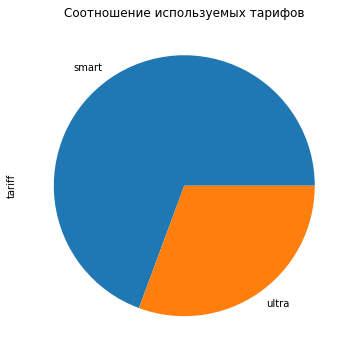

In [68]:
tariff_pie.plot.pie(figsize=(6, 6));
plt.title('Соотношение используемых тарифов')

In [69]:
print('Соотношение популярности тарифов smart/ultra = {:.2%}'.format(tariff_pie['smart']/tariff_pie['ultra']))

Соотношение популярности тарифов smart/ultra = 226.29%


**Вывод: Тариф smart в два раза превосходит по популярности тариф ultra.**

### Оценим распределение выручки раздельно по тарифам.

#### Ultra

Text(0.5, 0, 'Выручка, руб')

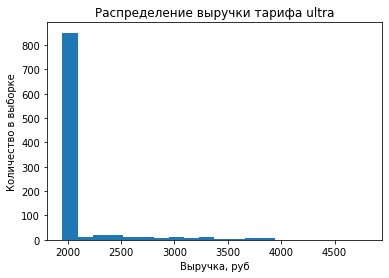

In [70]:
parametr = 'ultra'
df_ultra = df.query('tariff == @parametr')
df_ultra['rub_total'].plot(y='rub_total', title = 'Распределение выручки тарифа ultra', kind = 'hist', bins=20)
plt.ylabel('Количество в выборке')
plt.xlabel('Выручка, руб')    

Абонентская плата тарифа ultra = 1950

*Пользователи тарифа ultra редко переплачивают сверх абонентской платы.*

#### Smart

Text(0.5, 0, 'Выручка, руб')

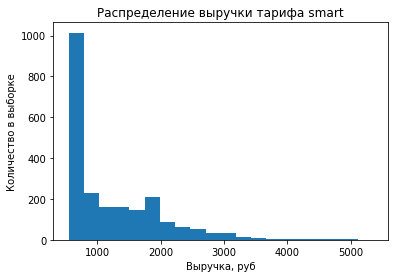

In [71]:
parametr = 'smart'
df_smart = df.query('tariff == @parametr')
df_smart['rub_total'].plot(y='rub_total', title = 'Распределение выручки тарифа smart', kind = 'hist', bins=20)
plt.ylabel('Количество в выборке')
plt.xlabel('Выручка, руб')


Абонентская плата тарифа smart = 550

**Пользователи тарифа smart нередко платят сверх абонентской платы. И это хорошо для оператора связи. Тем более, что таких пользователей на 100% больше, чем пользователей тарифа ultra**

Построим сводную таблицу с медианой и средним

In [72]:
svod = df.groupby('tariff').agg({'rub_total':['median','mean','sum','std','var']})
svod.columns=['median','mean','sum','std','var']
svod.style.format("{:.2f}")

,median,mean,sum,std,var
tariff,,,,,
smart,950.00,1187.22,2646318.00,749.56,561832.96
ultra,1950.00,2071.07,2040000.00,378.80,143491.24


<!-- **Вывод: Между тарифами есть различия и немаленькие. Средние значения и медианы по выручке различаются почти в два раза!**
**А вот общая выручка различается несильно smart принес 2028970 руб и ultra - 2503222 руб** -->

**Вывод: Между тарифами есть различия и немаленькие. Средние значения и медианы по тарифам по общей выручке различаются почти в два раза!**
**Общая выручка также различается smart принес 2646318.00  руб и ultra - 2040000.00 руб**

*При этом у нас, какая-то огромная ошибка std, сопоставимая со средним и медианой. Необходимо избавить датасет от экстремальных выбросов перед анализом статистических гипотез.*

### Оценим длительности разговоров за месяц для обоих тарифов.

Разработаем 'универсальную' функцию построения сводной таблицы. Для многократного использования.

In [73]:
# функция построениия сводной таблицы с расчетом среднего количество, дисперсии и стандартного отклонения:
# std - Compute standard deviation
# var - Compute variance of groups
# mean - Compute mean of groups

def calculate_pivot_table(column_name, index_name):
    pivot_table = pd.pivot_table(df, values=column_name, index=[index_name],aggfunc={column_name:[np.mean, np.std, np.var]})
    pivot_table.columns = ['mean','std','var',]
    return pivot_table
    #return pivot_table.style.format("{:.2f}")

Теперь построим сводную таблицу для длительности разговоров за месяц для обоих тарифов

In [74]:
pivot_table_call = calculate_pivot_table('month_calls_duration','tariff')
pivot_table_call

,mean,std,var
tariff,,,
smart,417.934948,190.313730,36219.315784
ultra,526.623350,317.606098,100873.633397


In [75]:
ratio_call = pivot_table_call.loc[pivot_table_call.index =='smart']['mean'][0] / pivot_table_call.loc[pivot_table_call.index =='ultra']['mean'][0]
print('Отношение длительности разговоров smart/ultra = {:.2%}'.format(ratio_call))

Отношение длительности разговоров smart/ultra = 79.36%


Построим частотные гистограммы для каждого из тарифов.

Text(0.5, 1.0, 'Длительность звонков в минутах, тариф Smart')

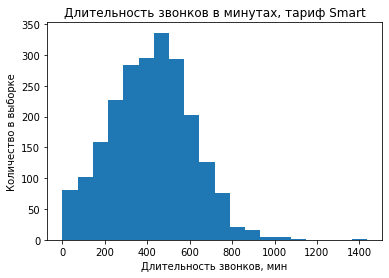

In [76]:
df_smart['month_calls_duration'].plot(kind='hist', bins=20)
plt.ylabel('Количество в выборке')
plt.xlabel('Длительность звонков, мин')
plt.title('Длительность звонков в минутах, тариф Smart')


Text(0.5, 1.0, 'Длительность звонков в минутах, тариф Ultra')

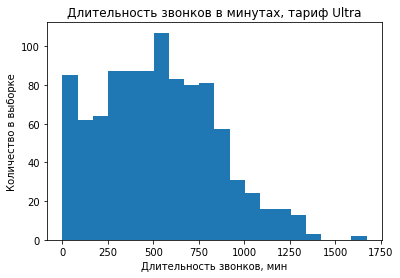

In [77]:
df_ultra['month_calls_duration'].plot(kind='hist', bins=20)
plt.ylabel('Количество в выборке')
plt.xlabel('Длительность звонков, мин')
plt.title('Длительность звонков в минутах, тариф Ultra')

In [78]:
# глянем в тарифы
tariffs.head(2)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [79]:
np.percentile(df_smart['month_calls_duration'],72)

531.0

**Вывод: Пользователи тарифа ultra наговаривают на 20% больше пользователей тарифа smart.**
**Бесплатная часть ultra = 3000 минут не вырабатывается пользователями, а бесплатная часть smart = 500 минут, может быть превышена 30% пользователей.**

### Оценим количество сообщений за месяц для обоих тарифов.

Строим сводную таблицу и гистограммы для каждого тарифа.

In [80]:
pivot_table_mess = calculate_pivot_table('month_messages_count','tariff')
pivot_table_mess

,mean,std,var
tariff,,,
smart,33.384029,28.227876,796.812958
ultra,49.363452,47.804457,2285.266143


In [81]:
ratio_sms = pivot_table_mess.loc[pivot_table_mess.index =='smart']['mean'][0] / pivot_table_mess.loc[pivot_table_mess.index =='ultra']['mean'][0]
print('Отношение количества sms сообщений smart/ultra = {:.2%}'.format(ratio_sms))

Отношение количества sms сообщений smart/ultra = 67.63%


Text(0.5, 1.0, 'Количество сообщений, тариф Smart')

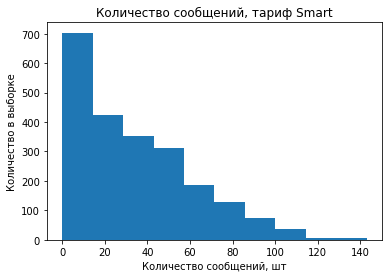

In [82]:
df_smart['month_messages_count'].plot(kind='hist', bins=10)
plt.ylabel('Количество в выборке')
plt.xlabel('Количество сообщений, шт')
plt.title('Количество сообщений, тариф Smart')

Text(0.5, 1.0, 'Количество сообщений, тариф Ultra')

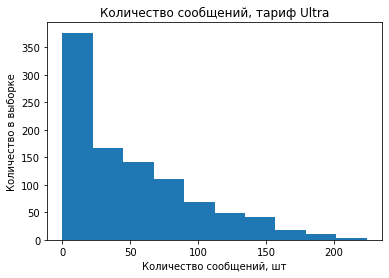

In [83]:
df_ultra['month_messages_count'].plot(kind='hist', bins=10)
plt.ylabel('Количество в выборке')
plt.xlabel('Количество сообщений, шт')
plt.title('Количество сообщений, тариф Ultra')


**Вывод: Пользователи тарифа ultra используют sms сообщения на 50% больше пользователей тарифа smart.** 
**Бесплатныq лимит по сообщениям на тарифе ultra (1000) - не вырабатывается, а на тарифе smart (50) может быть превышен в 4 раза!**

### Оценим интернет траффик за месяц для обоих тарифов.

Строим сводную таблицу и гистограммы для каждого тарифа.

In [84]:
pivot_table_inter = calculate_pivot_table('mb_used','tariff')
pivot_table_inter

,mean,std,var
tariff,,,
smart,16229.188425,5877.576978,3.454591e+07
ultra,19486.901523,10096.317202,1.019356e+08


In [85]:
ratio_inter = pivot_table_inter.loc[pivot_table_inter.index =='smart']['mean'][0] / pivot_table_inter.loc[pivot_table_inter.index =='ultra']['mean'][0]
print('Отношение количества трафика smart/ultra = {:.2%}'.format(ratio_inter))

Отношение количества трафика smart/ultra = 83.28%


Text(0.5, 1.0, 'Интернет траффик, тариф Smart')

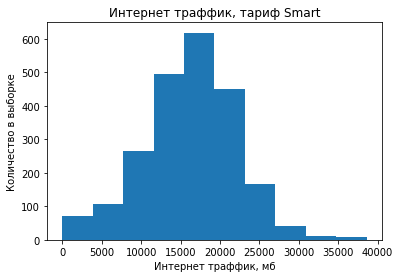

In [86]:
df_smart['mb_used'].plot(kind='hist', bins=10)
plt.ylabel('Количество в выборке')
plt.xlabel('Интернет траффик, мб')
plt.title('Интернет траффик, тариф Smart')

Text(0.5, 1.0, 'Интернет траффик, тариф Ultra')

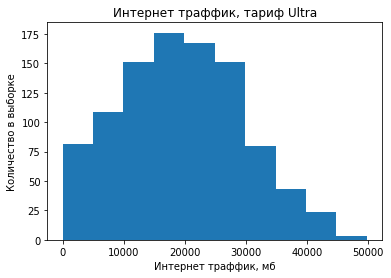

In [87]:
df_ultra['mb_used'].plot(kind='hist', bins=10)
plt.ylabel('Количество в выборке')
plt.xlabel('Интернет траффик, мб')
plt.title('Интернет траффик, тариф Ultra')


In [88]:
np.percentile(df_smart['mb_used'],45)

15839.0

In [89]:
np.percentile(df_ultra['mb_used'],85)

30076.199999999993

**Вывод: Пользователи тарифа ultra используют интернет траффик на 50% больше пользователей тарифа smart.**

**Бесплатныq лимит по трафику ultra (30720) превышается 15% пользователей, а на тарифе smart (15360) может быть превышен 55% пользователей!**

## Шаг 4. Проверяем гипотезы

### Гипотеза 1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.


*Сформулируем нулевую H0 и альтернативную гипотезу H1 следующим образом:*

- H0 выручка пользователей тарифов «Ультра» и «Смарт» не различается
- H1 выручка пользователей тарифов «Ультра» и «Смарт» различается


Для оценки гипотезы применим t-критерий стьюдента, предполагая при этом, что выборки независимы.

- так, как критерий чуствителен к выбросам  - уберем хвосты в выборках и посмотрим, что получилось.
- визуально оценим очищенные выборки при помощи гистограмм и диаграмм "ящика с усами"
- применим метод st.ttest_ind к нашим выборкам

In [175]:
#уберем хвосты в выборках

# функция возвращает межквартильный размах для колонки в виде кортежа
def generate_IQR_range(df,column):
    
    Q25 = df[column].quantile(0.25)                 
    Q75 = df[column].quantile(0.75) 
    MIN = df[column].min()
    MAX = df[column].max()
    
    IQR = Q75 - Q25
    
    left = Q25 - 1.5*IQR
    if left < MIN: left = MIN
    
    Right = Q75 + 1.5*IQR
    if Right > MAX: Right = MAX
     
    return (left, Right)

In [176]:
range_IQR_ultra = generate_IQR_range(df_ultra,'rub_total')

left = range_IQR_ultra[0]
right = range_IQR_ultra[1]

#получим датасет без экстемальных выбросов
df_ultra_good = df_ultra.query('@left <= rub_total & rub_total <= @right')

In [177]:
print('Из выборки ultra выброшено {} записи с эктремальными значениями.'.format(len(df_ultra) - len(df_ultra_good)))

Из выборки ultra выброшено 134 записи с эктремальными значениями.


In [178]:
range_IQR_smart = generate_IQR_range(df_smart,'rub_total')

left = range_IQR_smart[0]
right = range_IQR_smart[1]

df_smart_good = df_smart.query('@left <= rub_total & rub_total <= @right')


In [179]:
print('Из выборки smart выброшено {} записи с эктремальными значениями.'.format(len(df_smart) - len(df_smart_good)))

Из выборки smart выброшено 57 записи с эктремальными значениями.


In [180]:
df_smart_short = df_smart_good[['tariff','rub_total']]
df_ultra_short = df_ultra_good[['tariff','rub_total']]

In [181]:
# сборка
df_concat = pd.concat([df_smart_short, df_ultra_short])

In [182]:
df_smart.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2229.0,1246.506505,146.119496,1001.0,1121.0,1239.0,1376.0,1499.0
month_calls_duration,2229.0,417.934948,190.313730,0.0,282.0,422.0,545.0,1435.0
month_calls_count,2229.0,46.947510,21.039171,0.0,32.0,47.0,61.0,162.0
month_messages_count,2229.0,33.384029,28.227876,0.0,10.0,28.0,51.0,143.0
mb_used,2229.0,16229.188425,5877.576978,0.0,12658.0,16531.0,20068.0,38610.0
age,2229.0,46.556303,16.353371,18.0,32.0,47.0,62.0,75.0
tariff_on,2229.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
messages_included,2229.0,50.000000,0.000000,50.0,50.0,50.0,50.0,50.0
mb_per_month_included,2229.0,15360.000000,0.000000,15360.0,15360.0,15360.0,15360.0,15360.0
minutes_included,2229.0,500.000000,0.000000,500.0,500.0,500.0,500.0,500.0


Text(0.5, 1.0, 'Выручка (очищенная выборка), тариф Smart')

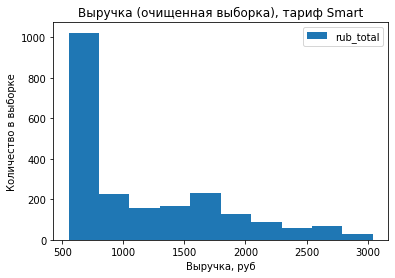

In [183]:
df_smart_short.plot(kind='hist', bins=10)
plt.ylabel('Количество в выборке')
plt.xlabel('Выручка, руб')
plt.title('Выручка (очищенная выборка), тариф Smart')

In [184]:
df_ultra.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,985.0,1263.094416,140.694908,1000.0,1143.0,1277.0,1381.0,1495.0
month_calls_duration,985.0,526.623350,317.606098,0.0,284.0,518.0,752.0,1673.0
month_calls_count,985.0,59.236548,35.562722,0.0,33.0,58.0,84.0,190.0
month_messages_count,985.0,49.363452,47.804457,0.0,6.0,38.0,79.0,224.0
mb_used,985.0,19486.901523,10096.317202,0.0,11785.0,19324.0,26863.0,49789.0
age,985.0,46.834518,17.107979,18.0,30.0,45.0,63.0,75.0
tariff_on,985.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
messages_included,985.0,1000.000000,0.000000,1000.0,1000.0,1000.0,1000.0,1000.0
mb_per_month_included,985.0,30720.000000,0.000000,30720.0,30720.0,30720.0,30720.0,30720.0
minutes_included,985.0,3000.000000,0.000000,3000.0,3000.0,3000.0,3000.0,3000.0


Text(0.5, 1.0, 'Выручка (очищенная выборка), тариф Ultra')

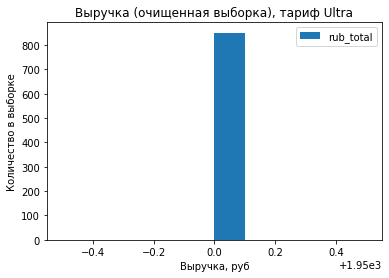

In [185]:
df_ultra_short.plot(kind='hist', bins=10)
plt.ylabel('Количество в выборке')
plt.xlabel('Выручка, руб')
plt.title('Выручка (очищенная выборка), тариф Ultra')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Text(0.5, 1.0, 'Boxplot - тарифы')

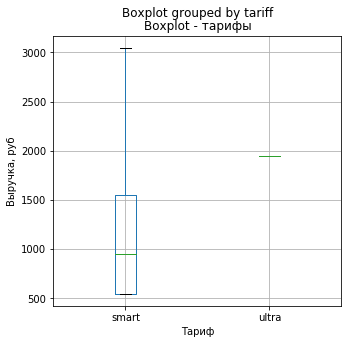

In [186]:
df_concat.boxplot('rub_total', by='tariff', figsize=(5,5)) 
plt.xlabel('Тариф')
plt.ylabel('Выручка, руб')
plt.title('Boxplot - тарифы')

Даже без критерия стьюдента понятно, что гипотеза H0 о равенстве выручки должна быть отвергнута.

Тем не менее, применим критерий стьюдента библиотеки scipy:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

*scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='two-sided')[source]
Calculate the T-test for the means of two independent samples of scores.*

*This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.*


In [187]:
alpha = 0.05

In [188]:
results = st.ttest_ind(df_ultra_good['rub_total'], df_smart_good['rub_total'])

In [189]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 9.773867734413409e-254
Отвергаем нулевую гипотезу


**Вывод: Средняя выручка пользователей тарифов «Ультра» и «Смарт» действительно различается. Гипотеза равенства выручки - отвергнута**

### Гипотеза 2: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

*Сформулируем нулевую H0 и альтернативную гипотезу H1:*

- H0 средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1 средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


Получим раздельные датасеты для Москвы и для регионов. И очистим данные от экстремальных значений, раздедьно по датасетам.

In [190]:
city = 'Москва'

df_moscow = df.query('city == @city')
range_IQR = generate_IQR_range(df_moscow,'rub_total')
left = range_IQR[0]
right = range_IQR[1]
df_good_moscow = df_moscow[['rub_total','city']].query('@left <= rub_total & rub_total <= @right')

In [191]:
info_m = df_good_moscow.describe().T
info_m

,count,mean,std,min,25%,50%,75%,max
rub_total,608.0,1470.151316,724.990841,550.0,652.0,1750.0,1950.0,3750.0


In [192]:
mean_moscow = info_m.iloc[0:1]['mean'][0]
print('Среднее значение выручки в серии Moscow = {:.2f} руб'.format(mean_moscow))

Среднее значение выручки в серии Moscow = 1470.15 руб


Text(0.5, 1.0, 'Выручка, Москва')

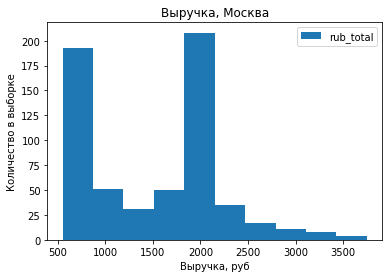

In [193]:
df_good_moscow.plot(kind='hist', bins=10)
plt.ylabel('Количество в выборке')
plt.xlabel('Выручка, руб')
plt.title('Выручка, Москва')

In [194]:
df_russia = df.query('not city == @city') # Регионы
range_IQR = generate_IQR_range(df_russia,'rub_total')
left = range_IQR[0]
right = range_IQR[1]
df_good_russia = df_russia[['rub_total','city']].query('@left <= rub_total & rub_total <= @right')

In [195]:
info_r = df_good_russia.describe().T

In [196]:
mean_russia = info_r.iloc[0:1]['mean'][0]
print('Среднее значение выручки в серии Russia = {:.2f} руб'.format(mean_russia))

Среднее значение выручки в серии Russia = 1435.49 руб


In [197]:
print('Разность средних в сериях Moscow - Russia = {:.2f} руб'.format(mean_moscow - mean_russia))

Разность средних в сериях Moscow - Russia = 34.66 руб


Text(0.5, 1.0, 'Выручка, Регионы')

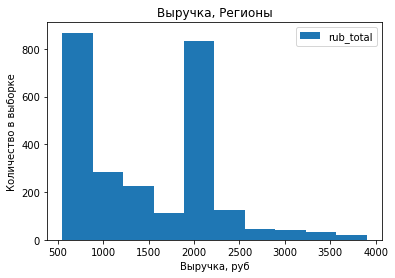

In [198]:
df_good_russia.plot(kind='hist', bins=10)
plt.ylabel('Количество в выборке')
plt.xlabel('Выручка, руб')
plt.title('Выручка, Регионы')

In [199]:
# сборка для boxplot
df_concat = pd.concat([df_good_moscow, df_good_russia])

def calculate_territory(row):
    if row['city'] == 'Москва':
        return 'Москва'
    else:
        return 'Регионы' 
    
df_concat['territory'] = df_concat.apply(calculate_territory, axis=1)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Text(0.5, 1.0, 'Территории')

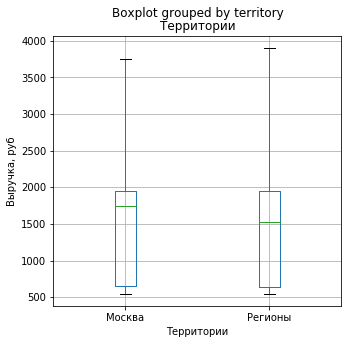

In [200]:
df_concat.boxplot('rub_total', by='territory', figsize=(5,5)) 
plt.xlabel('Территории')
plt.ylabel('Выручка, руб')
plt.title('Территории')

Предварительно видно, что выборки очень похожи. Хотя медиана распределения в Москве выше ( в Москве = 1598, против в регионах = 1375)

Применим критерий стьюдента (хотя и есть сомнения в его применимости):

In [201]:
alpha = 0.05

In [202]:
results = st.ttest_ind(df_good_moscow['rub_total'], df_good_russia['rub_total'])

In [117]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.30129218972407756
Не получилось отвергнуть нулевую гипотезу


**Вывод: Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.**
**Москва = Россия**
**Уровень статистической значимости 20%**

# Оценка гипотез при помощи bootstrap технологии

**Определение bootstrap**

Бутстрэп (англ. bootstrap) в статистике — практический компьютерный метод исследования распределения статистик вероятностных распределений, основанный на многократной генерации выборок методом Монте-Карло на базе имеющейся выборки. Позволяет просто и быстро оценивать самые разные статистики (доверительные интервалы, дисперсию, корреляцию и так далее) для сложных моделей. 
https://ru.wikipedia.org/wiki/%D0%91%D1%83%D1%82%D1%81%D1%82%D1%80%D1%8D%D0%BF_(%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0)


## Оценка гипотезы №1 при помощи bootstrap технологии.

 Напомним:
*Гипотеза 1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.*

Почему выбрана дополнительно технология bootstrap?

Потому что:
- критерий сьюдента рекомендовано применять либо к нормальным распределениям, либо к выборкам большого объема
- достаточно посмотреть на гистограмму, чтобы понять - наше распределение выручки ни разу ни 'нормальное'
- непонятно как оценивать объем нашей выборки (большая она или маленькая)

Text(0.5, 1.0, 'Выручка, Регионы')

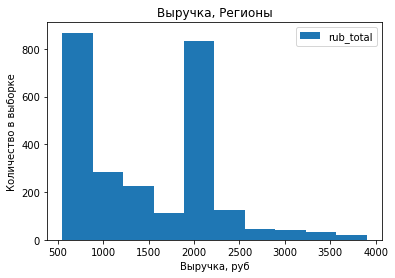

In [118]:
df_good_russia.plot(kind='hist', bins=10)
plt.ylabel('Количество в выборке')
plt.xlabel('Выручка, руб')
plt.title('Выручка, Регионы')

In [119]:
# количество итераций метода
bootstrap_len = 10000

# массив для накопления разницы между выборками
mean_difference_tariff = []

len_smart = len(df_smart)
len_ultra = len(df_ultra)

for i in range(bootstrap_len):
    # генерация выборки smart
    bootstrap_sample_smart = df_smart['rub_total'].sample(n=len_smart, replace=True)
    # среднее smart
    mean_smart = bootstrap_sample_smart.mean()
    # генерация выборки ultra
    bootstrap_sample_ultra = df_ultra['rub_total'].sample(n=len_ultra, replace=True)
    # среднее ultra
    mean_ultra = bootstrap_sample_ultra.mean()
    # накопление разности среднего и медианы по moscow и russia
    mean_difference_tariff.append(mean_ultra - mean_smart) 

Text(0.5, 1.0, 'Разность средних выручек по тарифам (bootstrap), руб')

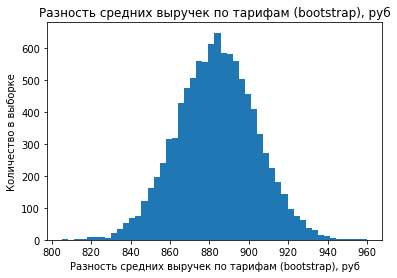

In [120]:
pd_series_mean_tariff = pd.Series(mean_difference_tariff)
pd_series_mean_tariff.plot(kind='hist', bins=50)
plt.ylabel('Количество в выборке')
plt.xlabel('Разность средних выручек по тарифам (bootstrap), руб')
plt.title('Разность средних выручек по тарифам (bootstrap), руб')

In [121]:
diff_mean_tariff = pd_series_mean_tariff.mean()
print('Разница между средними выручками по тарифам, приблизительно = {:.2f} руб'.format(diff_mean_tariff))

Разница между средними выручками по тарифам, приблизительно = 883.56 руб


In [122]:
# разница средних деленная на среднюю по ultra
diff_mean_tariff / df_smart['rub_total'].mean()

0.7442220088328607

**Подтвердился ранее сделвнный вывод по t -критерию  - Средняя выручка пользователей тарифов «Ультра» и «Смарт» действительно различается. Разница между выручками достигает 80% выручки от smart**

### Оценка гипотезы №2 при помощи bootstrap технологии.

Напомним:
*Гипотеза 2: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.*

Почему выбрана дополнительно технология bootstrap?

Потому что:
- критерий сьюдента рекомендовано применять либо к нормальным распределениям, либо к выборкам большого объема
- достаточно посмотреть на гистограмму, чтобы понять - наше распределение выручки ни разу ни 'нормальное'
- непонятно как оценивать объем нашей выборки (большая она или маленькая)

In [123]:
# количество итераций метода
bootstrap_len = 10000

# массив для накопления разницы между выборками
mean_difference = []

len_moscow = len(df_moscow)
len_russia = len(df_russia)

for i in range(bootstrap_len):
    # генерация выборки moscow
    bootstrap_sample_moscow = df_moscow['rub_total'].sample(n=len_moscow, replace=True)
    # среднее moscow
    mean_moscow = bootstrap_sample_moscow.mean()
    # генерация выборки russia
    bootstrap_sample_russia = df_russia['rub_total'].sample(n=len_russia, replace=True)
    # среднее russia
    mean_russia = bootstrap_sample_russia.mean()
    # накопление разности среднего и медианы по moscow и russia
    mean_difference.append(mean_moscow - mean_russia) 

Text(0.5, 1.0, 'Разность средних выручек по территориям (bootstrap), руб')

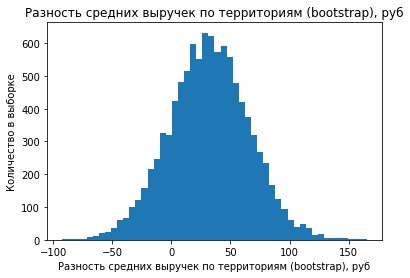

In [124]:
pd_series_mean = pd.Series(mean_difference)
pd_series_mean.plot(kind='hist', bins=50)
plt.ylabel('Количество в выборке')
plt.xlabel('Разность средних выручек по территориям (bootstrap), руб')
plt.title('Разность средних выручек по территориям (bootstrap), руб')

In [125]:
diff_mean = pd_series_mean.mean()
print('Разница между средними серий Moscow и Russia, приблизительно = {:.2f} руб'.format(diff_mean))

Разница между средними серий Moscow и Russia, приблизительно = 31.74 руб


In [126]:
# разница средних деленная на среднюю по москве и Регионам
print(diff_mean / df_moscow['rub_total'].mean())
print(diff_mean / df_russia['rub_total'].mean())

0.021392864783954066
0.021856220511696514


**Подтвердился ранее сделвнный вывод по t -критерию  - Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.**

**Разность средних выручек между Москвой и Регионами составляет приблизительно всего 2% от суммы средней выручки (и Москвы и Регионов).**

## Шаг 5. Общий выводы

**Выявлена разница между пользователями тарифов smart и ultra**

- Тариф smart в два раза превосходит по популярности тариф ultra.
- Пользователи тарифа smart нередко платят сверх абонентской платы. И это хорошо для оператора связи. Тем более, что таких пользователей на 100% больше, чем пользователей тарифа ultra
- Пользователи тарифа ultra наговаривают на 20% больше пользователей тарифа smart. Бесплатная часть ultra (3000 минут) не вырабатывается пользователями, а бесплатная часть smart (500 минут), может быть превышена 30% пользователей.
- Пользователи тарифа ultra используют sms сообщения на 50% больше пользователей тарифа smart. Бесплатныq лимит по  сообщениям на тарифе ultra (1000) - не вырабатывается, а на тарифе smart (50) может быть превышен в 4 раза!
- Активно используется интернет трафик. Пользователи тарифа ultra используют интернет траффик на 50% больше пользователей тарифа smart.Бесплатныq лимит по трафику ultra (30720) превышается 15% пользователей, а на тарифе smart лимит (15360) может быть превышен 55% пользователей!

Были проверены предложенные статистические гипотезы:
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Проверка производилась двумя различными метадами (t-тест Стьюдента и bootstrap-технология). 

Методы дали однообразный результат:

- Средняя выручка пользователей тарифов «Ультра» и «Смарт» существенно различаются. 
- Разница между средними выручками smart и ultra достигает 80% от величины средней выручки smart!
- Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
- Разность средних выручек между Москвой и Регионами составляет приблизительно всего 2% от суммы самой средней выручки (безотносительно Москва или регионы)

<!-- **Общая (валовая) выручка полученная с разных тарифов составляет для  smart 2028970 руб и для ultra - 2503222 руб**. Smart набрал сумму только за счет большего количества пользователей.

 -->
 
 **Общая выручка также различается - smart принес 2646318.00 руб и ultra - 2040000.00 руб.**

**Рекоммендации бизнесу:**

Обратить внимание на бесплатные лимиты тарифа smart, как особо популярного. Возможно, нужно незначительно увеличить лимиты, чтобы избежать оттока потребителей (никто не хочет переплачивать!). Так, как валовая выручка обеих тарифов не сильно различается и терять раздраженных пользователей smart не хотелось бы.

- средняя выручка по клиенту с тарифа ultra составляет 2071 руб, средняя выручка по клиенту с тарифу smart - 1187 руб.

Таким образом, желательно провести рекламную кампанию по переводу пользователей smart на тариф ultra!




